In [83]:
import pandas as pd
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import os
import matplotlib.pyplot as plt
import scipy.signal
import tifffile
from scipy.signal import butter, lfilter
from ibllib.io.video import *
import scipy.ndimage
import cv2
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from matplotlib.animation import PillowWriter
plt.rcParams['animation.ffmpeg_path'] = r'D:\ffmpeg\bin\ffmpeg.exe'

In [84]:
img_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Q_R2\20240402\acq1'
#reader=ScanImageTiffReader(img_path)

In [85]:
session_path = r'Z:\TM_Lab\Edward\Data\iblrig_data\Subjects\Q_R2\2024-04-02\001'
table_for_img = pd.read_csv(session_path+'\\table_for_img.csv')
table_for_img

,intervals_0,intervals_1,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times
0,0.000000,20.270901,181,366,1,181,NaN,0.5,369,-1,0.0,0.5,277
1,21.619699,77.504702,437,1239,1,433,0.5,NaN,1239,1,3.0,0.9,697
2,78.917099,132.055201,1297,2056,1,1294,0.5,NaN,2056,1,3.0,0.5,1585
3,133.462099,139.988601,2134,2175,-1,2130,NaN,0.5,2175,1,3.0,0.5,2169
4,141.261000,146.868301,2231,2263,-1,2228,0.5,NaN,2266,-1,0.0,0.5,2245
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2930.132998,2946.782300,44012,44212,1,44009,NaN,0.5,44215,-1,0.0,0.5,44044
154,2948.009799,2990.909900,44280,44888,-1,44277,NaN,0.5,44888,1,3.0,0.3,0
155,2992.252198,3012.855200,44944,45216,-1,44941,NaN,1.0,45216,1,3.0,0.5,44972
156,3014.101499,3026.183101,45270,45417,-1,45267,NaN,1.0,45417,1,3.0,0.5,45399


In [86]:
def find_frame_indices(dataframe, frame_rate, time_window, column_keyword):
    # Step 1: Identify the correct column
    for col in dataframe.columns:
        if column_keyword in col:
            target_column = col
            break
    else:  # If no column contains the keyword
        raise ValueError(f"No column found containing the keyword '{column_keyword}'")
    
    # Step 2: Calculate frame indices for each element
    indices_list = []
    for frame_number in dataframe[target_column]:
        # Calculate the number of frames for the given time window
        frames_before = int(round(frame_rate * time_window[0]))
        frames_after = int(round(frame_rate * time_window[1]))
        
        # Calculate the start and end frame
        start_frame = frame_number + frames_before
        end_frame = frame_number + frames_after
        
        # Generate the frame indices and add to the list
        indices = np.arange(start_frame, end_frame + 1)  # +1 because end is exclusive in np.arange
        indices_list.append(indices)
    
    return np.array(indices_list)

In [119]:
frame_rate = 14.85
goCue_frame_idx = find_frame_indices(table_for_img, frame_rate, (-1,1), 'goCue_times')
feedback_frame_idx = find_frame_indices(table_for_img, frame_rate, (-1,1), 'feedback_times')
firstmove_frame_idx = find_frame_indices(table_for_img, frame_rate, (-1,1), 'firstMovement_times')

In [120]:
reward_frame_idx = feedback_frame_idx[table_for_img['feedbackType'] == 1]
punish_frame_idx = feedback_frame_idx[table_for_img['feedbackType'] == -1]

In [89]:
leftroi_suite2p_path = os.path.join(img_path,'deep_interp','leftroi','suite2p','plane0')
rightroi_suite2p_path = os.path.join(img_path,'deep_interp','rightroi','suite2p','plane0')

In [90]:
leftroi_fluo = np.load(leftroi_suite2p_path+'\\F.npy', allow_pickle=True)
leftroi_neufluo = np.load(leftroi_suite2p_path+'\\Fneu.npy', allow_pickle=True)
raw_leftroi_stat = np.load(leftroi_suite2p_path+'\\stat.npy', allow_pickle=True)
leftroi_iscell = np.load(leftroi_suite2p_path+'\\iscell.npy', allow_pickle=True)
rightroi_fluo = np.load(rightroi_suite2p_path+'\\F.npy', allow_pickle=True)
rightroi_neufluo = np.load(rightroi_suite2p_path+'\\Fneu.npy', allow_pickle=True)
raw_rightroi_stat = np.load(rightroi_suite2p_path+'\\stat.npy', allow_pickle=True)
rightroi_iscell = np.load(rightroi_suite2p_path+'\\iscell.npy', allow_pickle=True)

In [91]:
leftroi_iscell = leftroi_iscell[:,0]==1
rightroi_iscell = rightroi_iscell[:,0]==1

In [92]:
leftroi_fluo = leftroi_fluo[leftroi_iscell,:]
leftroi_neufluo = leftroi_neufluo[leftroi_iscell,:]
leftroi_stat = raw_leftroi_stat[leftroi_iscell]
rightroi_fluo = rightroi_fluo[rightroi_iscell,:]
rightroi_neufluo = rightroi_neufluo[rightroi_iscell,:]
rightroi_stat = raw_rightroi_stat[rightroi_iscell]


In [93]:
def calculate_dff_with_moving_median(ca_imaging_data, frame_rate):
    # ca_imaging_data is a 2D NumPy array with shape (num_cells, frames)
    # frame_rate is the number of frames per second
    # Shift all fluorescence values to ensure they are above zero
    min_fluo = np.min(ca_imaging_data)
    if min_fluo <= 0:
        ca_imaging_data += (-min_fluo + 0.1)  # Shift fluorescence to slightly above zero

    window_size = int(20 * frame_rate)  # 20 seconds window
    num_cells, frames = ca_imaging_data.shape
    dff = np.zeros_like(ca_imaging_data)

    # Apply median filter to the entire dataset for each cell
    median_filtered = np.zeros_like(ca_imaging_data)
    for cell in range(num_cells):
        # Note: medfilt with kernel_size applied to 1D array per cell
        median_filtered[cell, :] = scipy.signal.medfilt(ca_imaging_data[cell, :], kernel_size=window_size)

    # Calculate ΔF/F for each cell using the filtered data as baseline
    for cell in range(num_cells):
        # Avoid division by zero
        baseline = median_filtered[cell, :]
        baseline[baseline == 0] = np.min(baseline[baseline > 0])  # replace 0 with the smallest non-zero baseline value

        dff[cell, :] = (ca_imaging_data[cell, :] - baseline) / baseline

    return dff

def calculate_dff_with_percentile(ca_imaging_data, percentile):
    # ca_imaging_data is a 2D NumPy array with shape (cell#, frames)
    # Shift all fluorescence values to ensure they are above zero
    min_fluo = np.min(ca_imaging_data)
    if min_fluo <= 0:
        ca_imaging_data += (-min_fluo + 0.1)  # Shift fluorescence to slightly above zero

    baseline = np.percentile(ca_imaging_data, percentile, axis=1)
    dff = (ca_imaging_data - baseline) / baseline
   
    return dff


def calculate_dff_with_moving_percentile(ca_imaging_data, frame_rate, moving_window=30, percentile=15):
    num_cells, num_frames = ca_imaging_data.shape
    
    # Shift all fluorescence values to ensure they are above zero
    min_fluo = np.min(ca_imaging_data)
    if min_fluo <= 0:
        ca_imaging_data += (-min_fluo + 0.1)  # Shift fluorescence to slightly above zero

    # Calculate the window length in frames
    window_length = int(frame_rate * moving_window)
    
    # Initialize the percentile filtered baseline array
    percentile_filtered = np.zeros((num_cells, num_frames))
    
    # Calculate the moving percentile
    for cell in range(num_cells):
        for frame in range(num_frames):
            start = max(0, frame - window_length // 2)
            end = min(num_frames, frame + window_length // 2)
            percentile_filtered[cell, frame] = np.percentile(ca_imaging_data[cell, start:end], percentile)
    
    # Calculate dF/F
    dff = np.zeros_like(ca_imaging_data)
    for cell in range(num_cells):
        baseline = percentile_filtered[cell, :]
        # Replace zero baselines with the smallest non-zero baseline value to prevent division by zero
        baseline[baseline == 0] = np.min(baseline[baseline > 0]) if np.any(baseline > 0) else np.min(baseline) + 0.1
        dff[cell, :] = (ca_imaging_data[cell, :] - baseline) / baseline

    return dff

3741.5

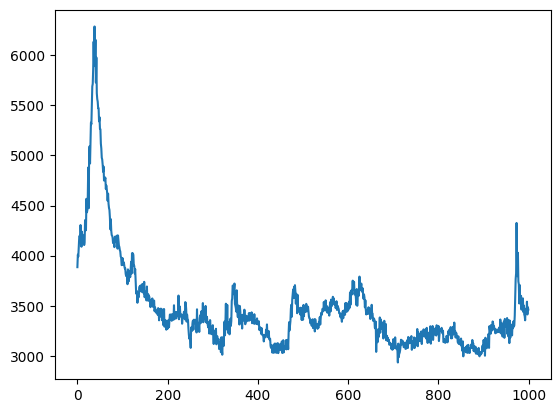

In [94]:
plt.plot(leftroi_fluo[0][0:1000])
np.percentile(leftroi_fluo[0], 25)

In [52]:
leftroi_fluo.shape

(16, 29162)

In [95]:
leftroi_dff = calculate_dff_with_moving_percentile(leftroi_fluo, frame_rate, moving_window=30, percentile=20)
leftroi_dff = np.hstack([np.zeros((leftroi_dff.shape[0],30)), leftroi_dff])
rightroi_dff = calculate_dff_with_moving_percentile(rightroi_fluo, frame_rate, moving_window=30, percentile=20)
rightroi_dff = np.hstack([np.zeros((rightroi_dff.shape[0],30)), rightroi_dff])

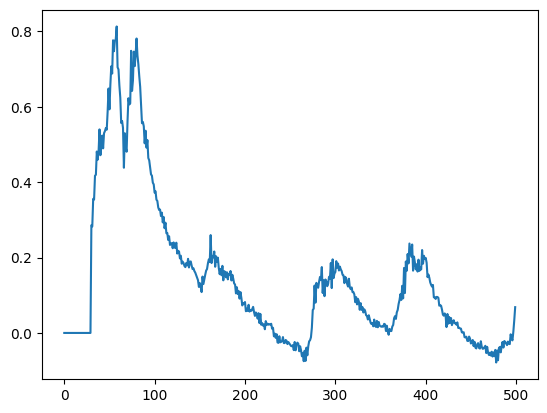

In [100]:
plt.plot(leftroi_dff[2][0:500])

In [101]:
def get_trial_PSTH(ca_imaging_data, frame_idx):
    # ca_imaging_data is a 2D NumPy array with shape (num_cells, frames)
    # frame_idx is 2D numpy array with shape (trials, num frames to be extracted for a trial(center frame is when event happens))
    # return zscored psth (num_trial, num_cells, num_frames_extracted)
    num_trials, num_frames_extracted = frame_idx.shape
    num_cells = ca_imaging_data.shape[0]
    psth = np.zeros((num_trials, num_cells, num_frames_extracted))
    z_psth = np.zeros_like(psth)  # Array to hold Z-score normalized PSTH

    for trial in range(num_trials):
        idx = frame_idx[trial, :]
        trial_psth = ca_imaging_data[:, idx]
        psth[trial, :, :] = trial_psth
        # Calculate mean and std for Z-score normalization, across frames for each cell
        mean_psth = np.mean(trial_psth, axis=1, keepdims=True)
        std_psth = np.std(trial_psth, axis=1, keepdims=True)
        
        # Avoid division by zero by setting std to 1 where it's 0 (or very close to 0)
        std_psth[std_psth == 0] = 1
        
        # Calculate Z-score
        z_trial_psth = (trial_psth - mean_psth) / std_psth
        
        # Store the Z-score normalized data
        z_psth[trial, :, :] = z_trial_psth
    #return psth
    return z_psth



In [121]:
leftroi_reward_psth = get_trial_PSTH(leftroi_dff, reward_frame_idx)
leftroi_punish_psth = get_trial_PSTH(leftroi_dff, punish_frame_idx)
rightroi_reward_psth = get_trial_PSTH(rightroi_dff, reward_frame_idx)
rightroi_punish_psth = get_trial_PSTH(rightroi_dff, punish_frame_idx)
mean_leftroi_reward_psth = np.mean(leftroi_reward_psth, axis=0)
mean_leftroi_punish_psth = np.mean(leftroi_punish_psth, axis=0)
mean_rightroi_reward_psth = np.mean(rightroi_reward_psth, axis=0)
mean_rightroi_punish_psth = np.mean(rightroi_punish_psth, axis=0)

leftroi_firstmove_psth = get_trial_PSTH(leftroi_dff, firstmove_frame_idx)
leftroi_goCue_psth = get_trial_PSTH(leftroi_dff, goCue_frame_idx)
rightroi_firstmove_psth = get_trial_PSTH(rightroi_dff, firstmove_frame_idx)
rightroi_goCue_psth = get_trial_PSTH(rightroi_dff, goCue_frame_idx)

mean_leftroi_firstmove_psth = np.mean(leftroi_firstmove_psth, axis=0)
mean_leftroi_goCue_psth = np.mean(leftroi_goCue_psth, axis=0)
mean_rightroi_firstmove_psth = np.mean(rightroi_firstmove_psth, axis=0)
mean_rightroi_goCue_psth = np.mean(rightroi_goCue_psth, axis=0)

In [103]:
def plot_mean_psth(mean_psth, frame_rate, title, ax, vmin=None, vmax=None):
    
    num_frames_extracted = mean_psth.shape[1]
    # Time axis correction to center at 0
    time_axis = np.linspace(-num_frames_extracted/2, num_frames_extracted/2, num_frames_extracted) / frame_rate + 1/frame_rate/2
    start_time = time_axis[0]
    end_time = time_axis[-1]
    num_cells = mean_psth.shape[0]

    # Use the provided ax for plotting, include vmin and vmax for color normalization
    cax = ax.imshow(mean_psth, aspect='auto', origin='lower', cmap='viridis', 
                    extent=[start_time, end_time, 0, num_cells], vmin=vmin, vmax=vmax)

    fig = plt.gcf()
    fig.colorbar(cax, ax=ax, label='Z-score Normalized Activity')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cell Index')
    ax.set_title(f'Mean PSTH Across {title} Trials')

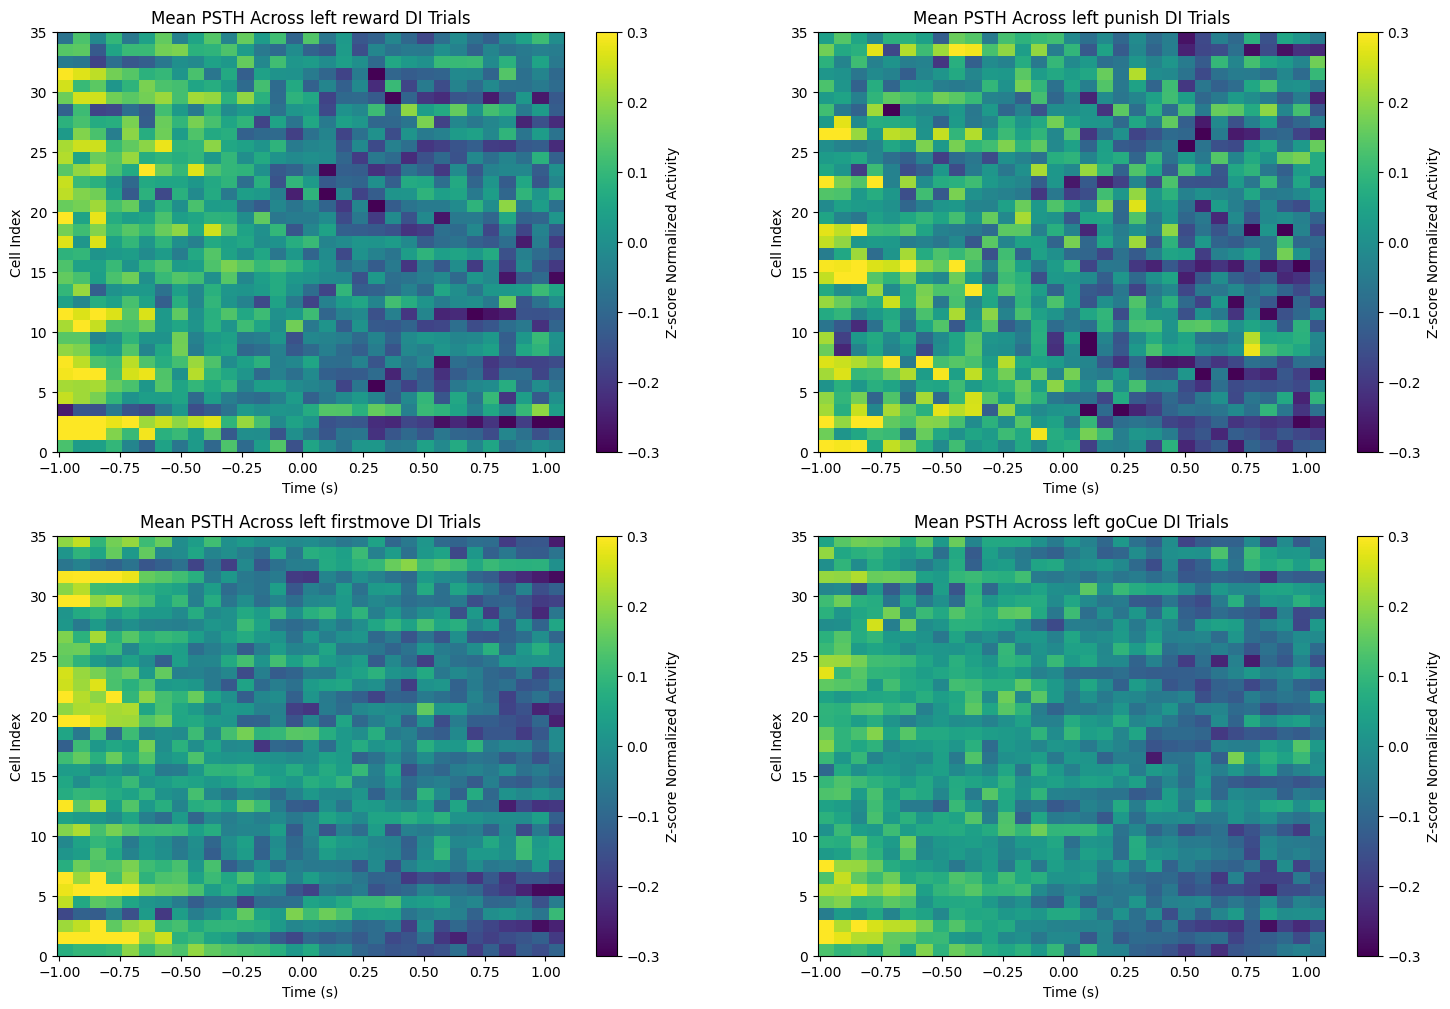

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
psth2plot = [mean_leftroi_reward_psth, mean_leftroi_punish_psth, mean_leftroi_firstmove_psth, mean_leftroi_goCue_psth]
titles = ["left reward DI", "left punish DI", "left firstmove DI", "left goCue DI"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate, title, ax, vmin=-0.3, vmax=0.3)

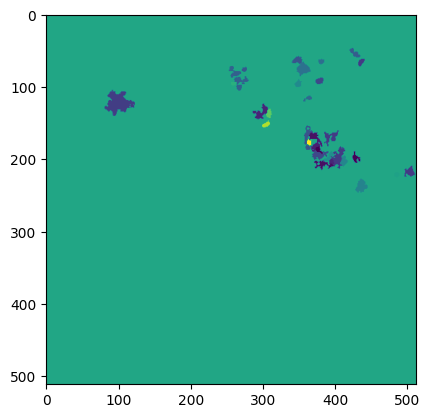

In [105]:
im = np.zeros((512,512))
num_cells = mean_leftroi_reward_psth.shape[0]
for n in range(0,num_cells):
    ypix = leftroi_stat[n]['ypix']
    xpix = leftroi_stat[n]['xpix']
    im[ypix,xpix] = np.mean(mean_leftroi_reward_psth[n, 31:41])

plt.imshow(im)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
psth2plot = [mean_rightroi_reward_psth, mean_rightroi_punish_psth, mean_rightroi_firstmove_psth, mean_rightroi_goCue_psth]
titles = ["right reward DI", "right punish DI", "right firstmove DI", "right goCue DI"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate, title, ax, vmin=-0.3, vmax=0.3)

In [ ]:
im = np.zeros((512,512))
num_cells = mean_rightroi_reward_psth.shape[0]
for n in range(0,num_cells):
    ypix = rightroi_stat[n]['ypix']
    xpix = rightroi_stat[n]['xpix']
    im[ypix,xpix] = np.mean(mean_rightroi_reward_psth[n, 31:41])

plt.imshow(im)
plt.show()

In [114]:
def sort_psth_by_average_response(mean_psth, post, frame_rate):
    num_cells, num_frames = mean_psth.shape
    midpoint = num_frames//2
    window_start = midpoint
    window_end = window_start + int(post*frame_rate)

    # Calculate average response in the defined window
    average_responses = np.mean(mean_psth[:, window_start:window_end], axis=1)

    # Get sorted indices, from highest to lowest average response
    sorted_indices_average = np.argsort(-average_responses)

    # Sort the PSTH array
    sorted_psth_average = mean_psth[sorted_indices_average]
    
    return sorted_indices_average, sorted_psth_average

In [ ]:
left_reward_sort_idx,_ = sort_psth_by_average_response(mean_leftroi_reward_psth,1,frame_rate)
left_punish_sort_idx,_ = sort_psth_by_average_response(mean_leftroi_punish_psth,1,frame_rate)
left_firstmove_sort_idx,_ = sort_psth_by_average_response(mean_leftroi_firstmove_psth,1,frame_rate)
left_goCue_sort_idx,_ = sort_psth_by_average_response(mean_leftroi_goCue_psth,1,frame_rate)
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
psth2plot = [mean_leftroi_reward_psth[left_reward_sort_idx,:], 
             mean_leftroi_punish_psth[left_punish_sort_idx,:], 
             mean_leftroi_firstmove_psth[left_firstmove_sort_idx,:], 
             mean_leftroi_goCue_psth[left_goCue_sort_idx,:]
             ]
titles = ["left reward sorted DI", "left punish sorted DI", "left firstmove sorted DI", "left goCue sorted DI"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate, title, ax, vmin=-0.3, vmax=0.3)

In [125]:
print(left_reward_sort_idx)
print(left_goCue_sort_idx)

[ 3 28 32 12  0 16 21  9  4 22 26 27 13  8 34 20 17 14 33 30 15 19 31 24
  5  7 10  1 18 23 25  6 29 11  2]
[30 12 15 33 19 27 16 32 26 25  8  3 11  9 14 17 29  7  4 13 20 28 21 10
 18 34 23 22 24 31  6  1  0  5  2]


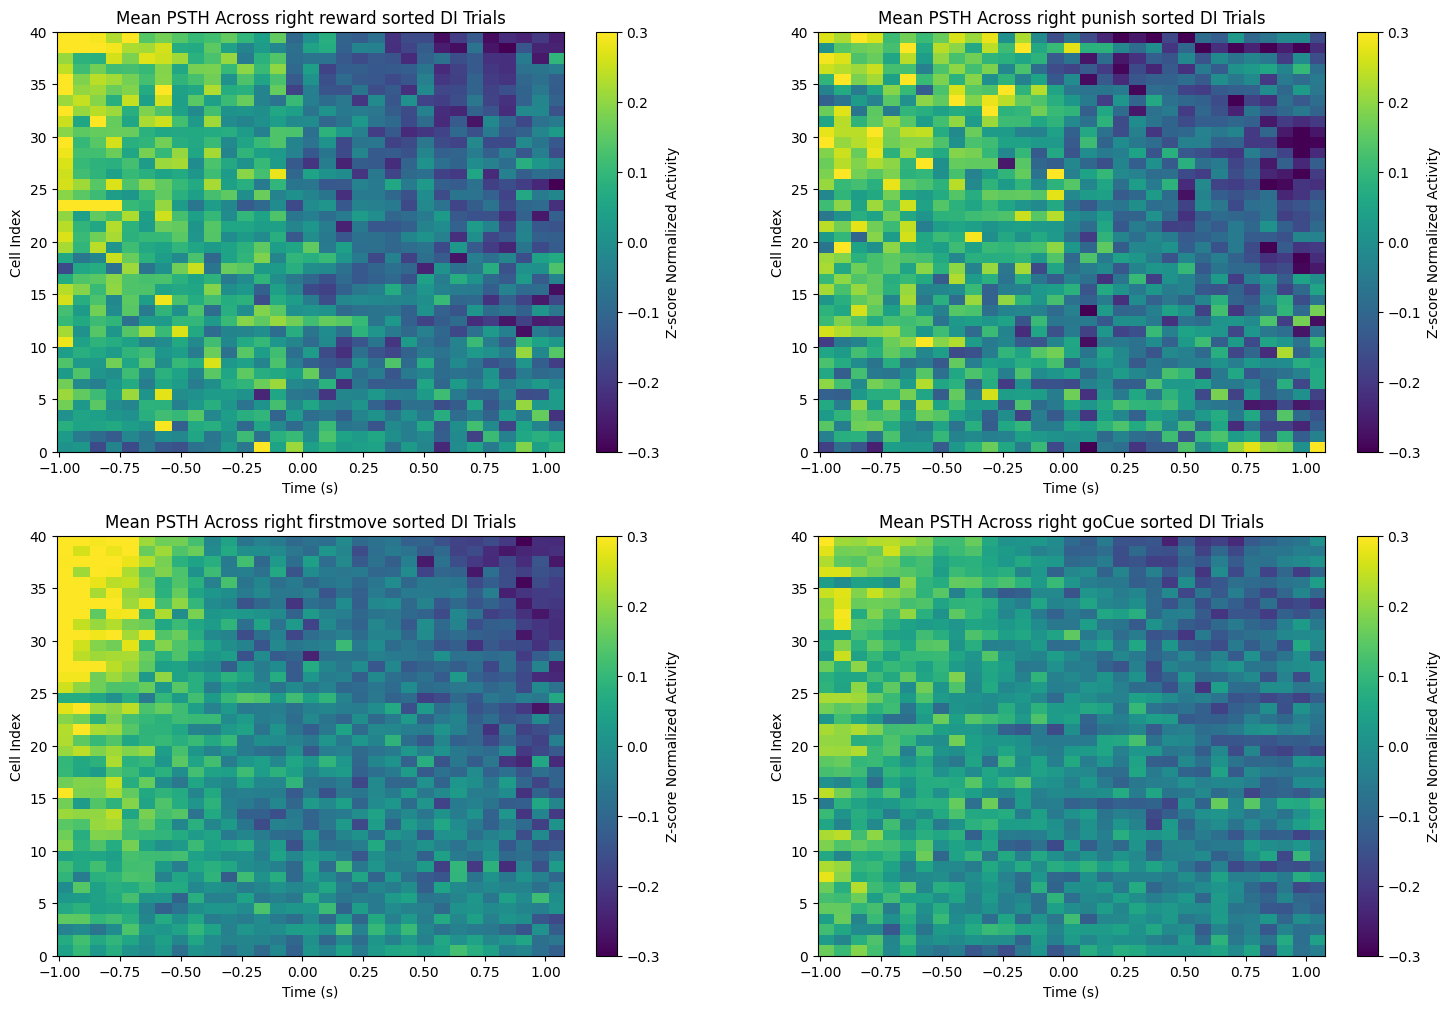

In [126]:
right_reward_sort_idx,_ = sort_psth_by_average_response(mean_rightroi_reward_psth,1,frame_rate)
right_punish_sort_idx,_ = sort_psth_by_average_response(mean_rightroi_punish_psth,1,frame_rate)
right_firstmove_sort_idx,_ = sort_psth_by_average_response(mean_rightroi_firstmove_psth,1,frame_rate)
right_goCue_sort_idx,_ = sort_psth_by_average_response(mean_rightroi_goCue_psth,1,frame_rate)
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
psth2plot = [mean_rightroi_reward_psth[right_reward_sort_idx,:], 
             mean_rightroi_punish_psth[right_punish_sort_idx,:], 
             mean_rightroi_firstmove_psth[right_firstmove_sort_idx,:], 
             mean_rightroi_goCue_psth[right_goCue_sort_idx,:]
             ]
titles = ["right reward sorted DI", "right punish sorted DI", "right firstmove sorted DI", "right goCue sorted DI"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate, title, ax, vmin=-0.3, vmax=0.3)

In [78]:
def load_tiff(filepath):
    # Open the TIFF file
    with tifffile.TiffFile(filepath) as tif:
        # Initialize an empty list to hold the data from each page
        pages = []
        
        # Iterate over each page in the TIFF file
        for page in tif.pages:
            # Read the page into a NumPy array and append it to the list
            pages.append(page.asarray())
        
        # Stack the pages along a new first dimension
        tif_array = np.stack(pages, axis=0)
        
    return tif_array

In [142]:
mc_leftroi_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\O_L3\20240326\acq2\suite2p\plane0\reg_tif\concatenated_top_images.tif'

In [151]:
def extract_raw_fluo(stat, raw_img_filepath):
    # using rois from suite2p identified using deep interp images to get raw fluorescence of those cells
    raw_img = load_tiff(raw_img_filepath)
    num_cells = len(stat)
    num_frames, x, y = raw_img.shape
    F_raw = np.zeros((num_cells, num_frames))
    for i in range(num_cells):
        num_pixels = len(stat[i]['xpix'])
        pixel_fluo = []
        for j in range(num_pixels):
            pixel_fluo.append(raw_img[:,stat[i]['xpix'][j], stat[i]['ypix'][j]].squeeze())
        mean_pixel_fluo = np.mean(np.stack(pixel_fluo, axis = 1), axis = 1)
        F_raw[i,:] = mean_pixel_fluo
    return F_raw
    

In [152]:
try:
    np.load(leftroi_suite2p_path+'\\F_raw.npy', allow_pickle=True)
except:
    leftroi_raw_fluo = extract_raw_fluo(raw_leftroi_stat, mc_leftroi_path)
    np.save(leftroi_suite2p_path+'\\F_raw.npy', leftroi_raw_fluo, allow_pickle=True)
leftroi_raw_fluo = leftroi_raw_fluo[leftroi_iscell,:]

In [298]:

leftroi_raw_dff = calculate_dff_with_moving_percentile(leftroi_raw_fluo, frame_rate, moving_window=20, percentile=25)

In [250]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def lowpass_filter_2d(data, cutoff, fs, order=5):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_data[i, :] = lowpass_filter(data[i, :], cutoff, fs, order)
    return filtered_data



In [300]:
leftroi_lf_fluo = lowpass_filter_2d(leftroi_raw_fluo, 5, frame_rate)
leftroi_lf_dff = calculate_dff_with_moving_percentile(leftroi_lf_fluo, frame_rate, moving_window=20, percentile=25)

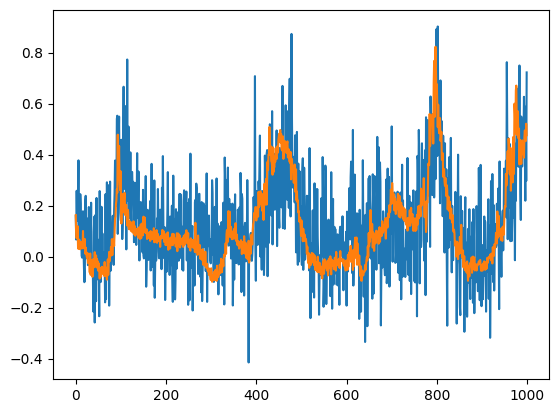

In [302]:
plt.plot(leftroi_raw_dff[0,4000:5000])
#plt.plot(leftroi_lf_dff[0,4000:5000])
plt.plot(leftroi_dff[0,4000:5000])

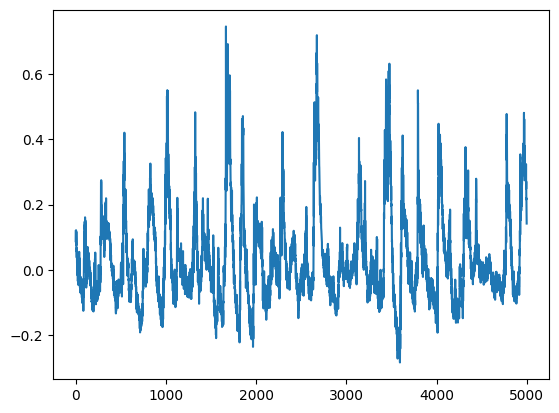

In [168]:
plt.plot(leftroi_dff[0,5000:10000])

In [303]:
leftroi_raw_reward_psth = get_trial_PSTH(leftroi_raw_dff, reward_frame_idx)
leftroi_raw_punish_psth = get_trial_PSTH(leftroi_raw_dff, punish_frame_idx)
# rightroi_reward_psth = get_trial_PSTH(rightroi_dff, reward_frame_idx)
# rightroi_punish_psth = get_trial_PSTH(rightroi_dff, punish_frame_idx)
mean_leftroi_raw_reward_psth = np.mean(leftroi_raw_reward_psth, axis=0)
mean_leftroi_raw_punish_psth = np.mean(leftroi_raw_punish_psth, axis=0)
# mean_rightroi_reward_psth = np.mean(rightroi_reward_psth, axis=0)
# mean_rightroi_punish_psth = np.mean(rightroi_punish_psth, axis=0)

leftroi_raw_firstmove_psth = get_trial_PSTH(leftroi_raw_dff, firstmove_frame_idx)
leftroi_raw_goCue_psth = get_trial_PSTH(leftroi_raw_dff, goCue_frame_idx)
# rightroi_firstmove_psth = get_trial_PSTH(rightroi_dff, firstmove_frame_idx)
# rightroi_goCue_psth = get_trial_PSTH(rightroi_dff, goCue_frame_idx)

mean_leftroi_raw_firstmove_psth = np.mean(leftroi_raw_firstmove_psth, axis=0)
mean_leftroi_raw_goCue_psth = np.mean(leftroi_raw_goCue_psth, axis=0)
# mean_rightroi_firstmove_psth = np.mean(rightroi_firstmove_psth, axis=0)
# mean_rightroi_goCue_psth = np.mean(rightroi_goCue_psth, axis=0)

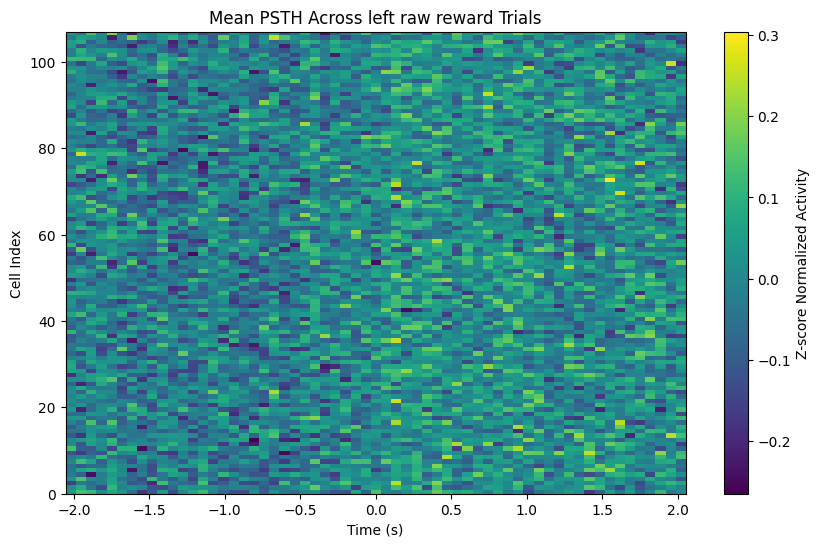

In [304]:
plot_mean_psth(mean_leftroi_raw_reward_psth, frame_rate, title='left raw reward')

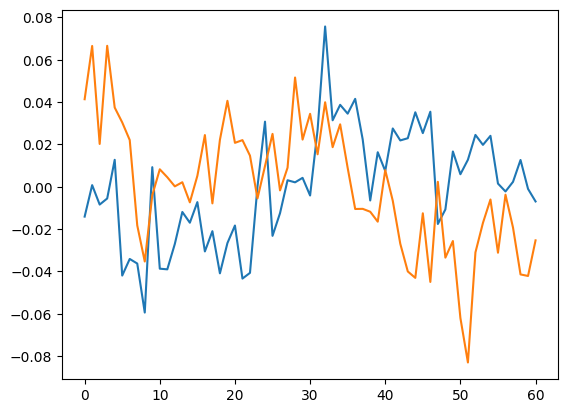

In [246]:
plt.plot(np.mean(mean_leftroi_raw_reward_psth, axis=0))
plt.plot(np.mean(mean_leftroi_raw_punish_psth, axis=0))

In [305]:
leftroi_lf_reward_psth = get_trial_PSTH(leftroi_lf_dff, reward_frame_idx)
leftroi_lf_punish_psth = get_trial_PSTH(leftroi_lf_dff, punish_frame_idx)
# rightroi_reward_psth = get_trial_PSTH(rightroi_dff, reward_frame_idx)
# rightroi_punish_psth = get_trial_PSTH(rightroi_dff, punish_frame_idx)
mean_leftroi_lf_reward_psth = np.mean(leftroi_lf_reward_psth, axis=0)
mean_leftroi_lf_punish_psth = np.mean(leftroi_lf_punish_psth, axis=0)
# mean_rightroi_reward_psth = np.mean(rightroi_reward_psth, axis=0)
# mean_rightroi_punish_psth = np.mean(rightroi_punish_psth, axis=0)

leftroi_lf_firstmove_psth = get_trial_PSTH(leftroi_lf_dff, firstmove_frame_idx)
leftroi_lf_goCue_psth = get_trial_PSTH(leftroi_lf_dff, goCue_frame_idx)
# rightroi_firstmove_psth = get_trial_PSTH(rightroi_dff, firstmove_frame_idx)
# rightroi_goCue_psth = get_trial_PSTH(rightroi_dff, goCue_frame_idx)

mean_leftroi_lf_firstmove_psth = np.mean(leftroi_lf_firstmove_psth, axis=0)
mean_leftroi_lf_goCue_psth = np.mean(leftroi_lf_goCue_psth, axis=0)
# mean_rightroi_firstmove_psth = np.mean(rightroi_firstmove_psth, axis=0)
# mean_rightroi_goCue_psth = np.mean(rightroi_goCue_psth, axis=0)

In [261]:
leftroi_raw_reward_psth.shape

(140, 107, 61)

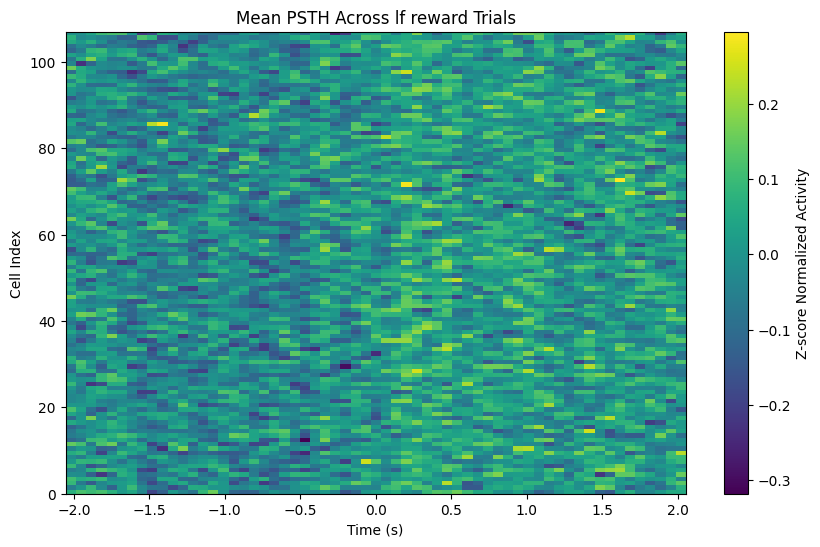

In [306]:
plot_mean_psth(mean_leftroi_lf_reward_psth, frame_rate, 'lf reward')

Behavior Video

In [323]:
table_for_video = pd.read_csv(session_path+'\\table_for_video.csv')
table_for_video

,intervals_0,intervals_1,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times
0,0.000000,11.362502,110,265,1,0,NaN,0.5,278,-1,0.0,0.5,254
1,12.582600,21.204602,599,860,-1,0,0.5,NaN,872,-1,0.0,0.9,853
2,22.368200,35.026603,1175,1694,-1,0,0.5,NaN,1707,-1,0.0,0.9,1691
3,36.199400,45.088802,2066,2362,1,0,0.5,NaN,2362,1,3.0,0.9,2358
4,46.348800,51.451002,2728,2747,1,0,0.5,NaN,2747,1,3.0,0.5,2738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,2524.628699,2536.168502,152258,152734,1,0,NaN,0.5,152747,-1,0.0,0.5,152706
282,2537.331799,2543.204301,153016,153219,-1,0,NaN,0.5,153219,1,3.0,0.5,153212
283,2544.348600,2555.406201,153628,153956,-1,0,NaN,1.0,153956,1,3.0,0.5,153951
284,2556.811899,2562.640902,154237,154393,1,0,0.5,NaN,154393,1,3.0,0.5,154387


In [325]:
video_path = r'Z:\TM_Lab\Edward\Data\iblrig_data\Subjects\O_L3\2024-03-26\003\raw_video_data\_iblrig_leftCamera.raw.avi'
video_meta = get_video_meta(video_path, one=None)
video_frame_rate = video_meta['fps']

In [387]:
feedback_video_idx = find_frame_indices(table_for_video, video_frame_rate, (0,2), 'feedback_times')
firstmove_video_idx = find_frame_indices(table_for_video, video_frame_rate, (0,2), 'firstMovement_times')
reward_video_idx = feedback_video_idx[table_for_video['feedbackType'] == 1]

In [369]:
def rgb_to_grayscale(rgb_image):
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])
def downsample_video_by_averaging(video, downsample_factor):
    """
    Downsample a video by averaging over pixel blocks.
    
    Parameters:
    - video: a 3D NumPy array with shape (frames, height, width) representing the grayscale video.
    - downsample_factor: a tuple (factor_height, factor_width) defining the
      downsampling factor for the height and width dimensions, respectively.
    
    Returns:
    - downsampled_video: the downsampled video as a NumPy array.
    """
    frames, height, width = video.shape

    # Calculate the size of the downsampled image
    new_height = height // downsample_factor[0]
    new_width = width // downsample_factor[1]

    # Check if the dimensions fit perfectly
    if height % downsample_factor[0] != 0 or width % downsample_factor[1] != 0:
        raise ValueError("Image dimensions must be divisible by the downsample factor.")

    # Reshape and average
    downsampled_video = video[:, :new_height * downsample_factor[0], :new_width * downsample_factor[1]]
    downsampled_video = downsampled_video.reshape(frames, new_height, downsample_factor[0], new_width, downsample_factor[1])
    downsampled_video = downsampled_video.mean(axis=(2, 4))

    return downsampled_video


In [350]:

#video_seg = downsample_image_by_averaging(video_seg, (2,2))

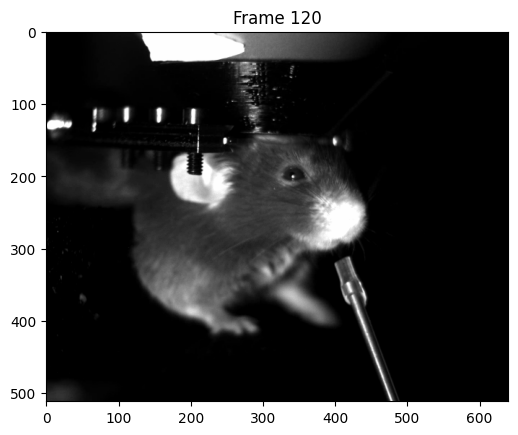

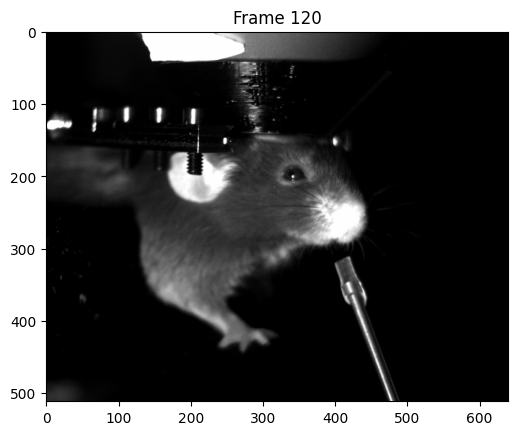

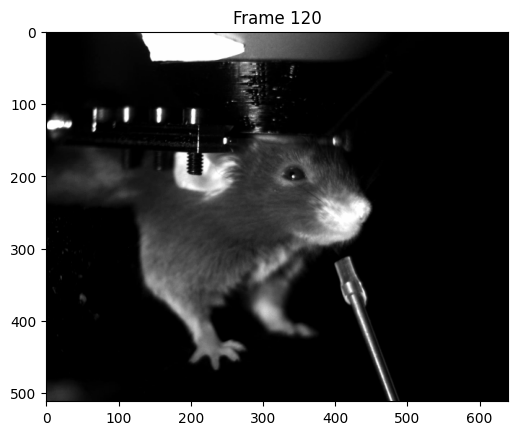

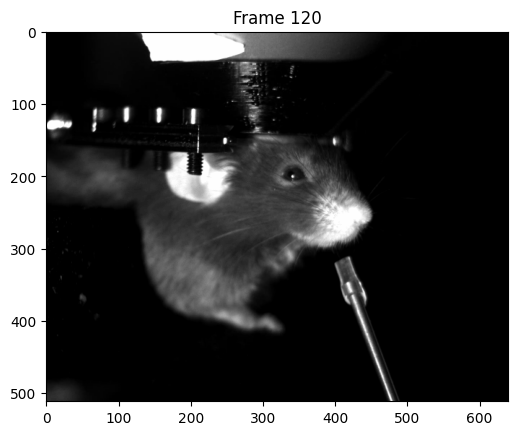

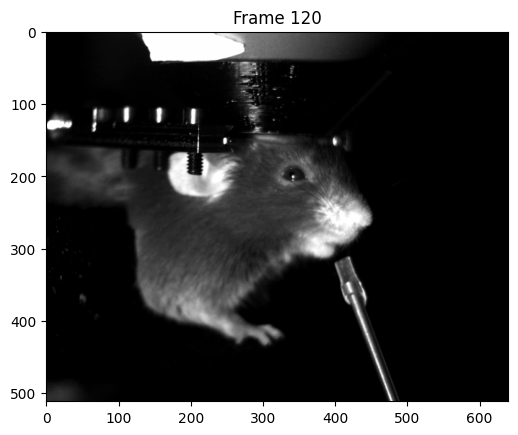

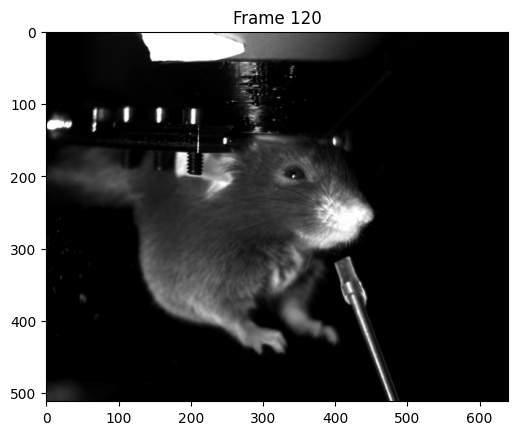

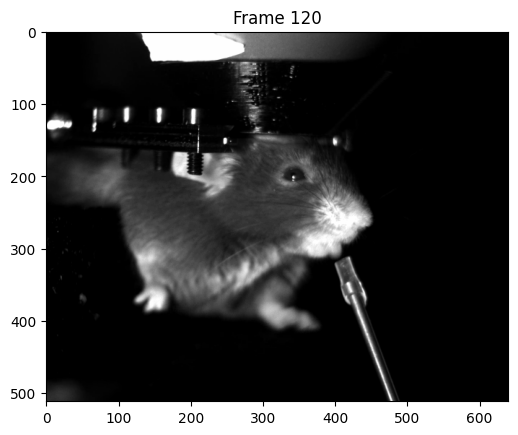

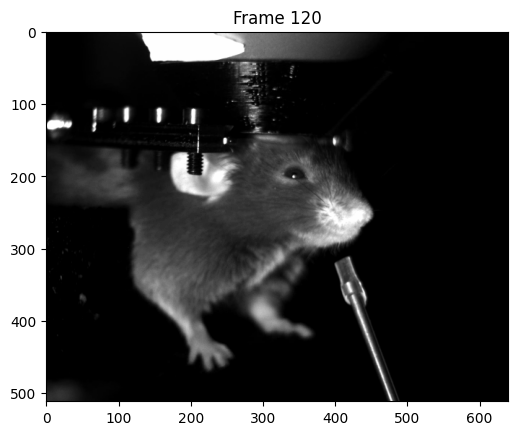

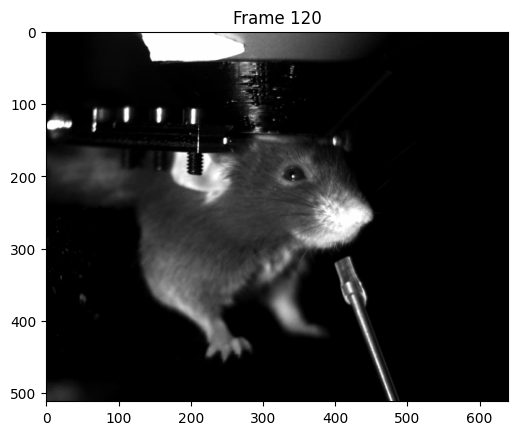

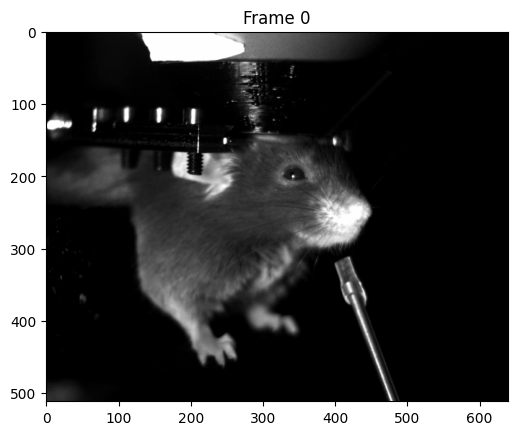

In [388]:
try:
    os.mkdir('behavior_video_segments')
except:
    pass

for i in range(50,60):
    video_seg = get_video_frames_preload(video_path, frame_numbers=reward_video_idx[i], mask=np.s_[:, :, :], as_list=False,
                                func=rgb_to_grayscale, quiet=False)
    video_seg = downsample_video_by_averaging(video_seg, (2,2))
    fig, ax = plt.subplots()

    def update(n):
        ax.clear()
        ax.imshow(video_seg[n], cmap='gray', vmin=0, vmax=255)
        ax.set_title(f"Frame {n}")

    anim = FuncAnimation(fig, update, frames=len(video_seg), interval=int(1000 / video_frame_rate))
    writer = FFMpegWriter(fps=video_frame_rate, metadata=dict(artist='Me'), bitrate=1800)
    segFileStr = "reward_" + str(i) +".mp4"
    savePath = os.path.join('behavior_video_segments',segFileStr)
    anim.save(savePath, writer=writer)

In [365]:
savePath = os.path.join(session_path, "behavior_video_segments", segFileStr)
savePath

'Z:\\TM_Lab\\Edward\\Data\\iblrig_data\\Subjects\\O_L3\\2024-03-26\\003\\behavior_video_segments\\reward_120.gif'

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
segFileStr = 'reward_' + str(1) +'.mp4'
out = cv2.VideoWriter(os.path.join(session_path, 'behavior_video_segments', segFileStr), fourcc, 20.0, (video_seg.shape[2], video_seg.shape[1]), False)

for i in range(video_seg.shape[0]):
    out.write(video_seg[i].astype('uint8'))

out.release()  # Release everything if job is finished

# Embed the video in the notebook
from IPython.display import Video
Video("output.mp4")